In [1]:
import pandas as pd
import numpy as np
import locale
locale.setlocale(locale.LC_ALL, '')
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing 
import re

plt.style.use('fivethirtyeight')

# 노트북 안에 그래프 그리기
%matplotlib inline
# 그래프 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus']=False

# 컬럼을 다 보여주는 함수
from IPython.display import display
pd.options.display.max_columns = None

# 한글 font 설정
import matplotlib.font_manager as fm

font_name = fm.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
plt.rc('font',family = font_name)
mpl.rcParams['axes.unicode_minus'] = False

In [42]:
Product = pd.read_csv('Pruduct.csv')
print("Product")
Search1 = pd.read_csv('Search1.csv')
print("Search1")
Search2 = pd.read_csv('Search2.csv')
print("Search2")
Custom = pd.read_csv('Custom.csv')
print("Custom")
Master = pd.read_csv('Master.csv')
print("Master")
Session = pd.read_csv('Session.csv')
print("Session")

Product
Search1
Search2
Custom
Master
Session


In [3]:
print('Product의 shape',Product.shape)
print("-----------------------------")
print('Search1의 shape',Search1.shape)
print("-----------------------------")
print('Search2의 shape',Search2.shape)
print("-----------------------------")
print('Custom의 shape',Custom.shape)
print("-----------------------------")
print('Master의 shape',Master.shape)
print("-----------------------------")
print('Session의 shape',Session.shape)

Product의 shape (5024906, 8)
-----------------------------
Search1의 shape (2884943, 4)
-----------------------------
Search2의 shape (8051172, 3)
-----------------------------
Custom의 shape (671679, 3)
-----------------------------
Master의 shape (847652, 5)
-----------------------------
Session의 shape (2712907, 9)


# 1. 데이터 정제 및 탐색

## 1.1 Product

In [4]:
Product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5024906 entries, 0 to 5024905
Data columns (total 8 columns):
CLNT_ID      int64
SESS_ID      int64
HITS_SEQ     int64
PD_C         int64
PD_ADD_NM    object
PD_BRA_NM    object
PD_BUY_AM    object
PD_BUY_CT    object
dtypes: int64(4), object(4)
memory usage: 306.7+ MB


In [5]:
Product.isnull().sum()

CLNT_ID      0
SESS_ID      0
HITS_SEQ     0
PD_C         0
PD_ADD_NM    0
PD_BRA_NM    0
PD_BUY_AM    0
PD_BUY_CT    0
dtype: int64

In [43]:
# 행동 한번으로 상품을 구매할 수 없다.
Product = Product[Product['HITS_SEQ'] != 1]

In [7]:
Product.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT
0,4139680,7605037,12,642112,색상:워터멜론,[바비브라운],"39,000",1
1,4140076,10189797,13,570603,색상:BLK0_(BLK0)BLACK|사이즈:120 / 2개,데상트,"39,000",2
2,4142395,6158159,85,179538,(not set),[아베다],"39,000",1
3,4144914,7935714,12,554336,색상:블랙|사이즈:160cm(12~13세) / 1개,아디다스 키즈,"39,000",1
4,4144917,6406509,78,190306,5개,데코르테,"39,000",5


- PD_ADD_NM
    - 정제가 필요할것같은데 좀 더 생각해보자

In [44]:
# PD_ADD_NM(추가정보) 열에서 | or / 로 세부정보를 구분
# |를 /로 변경하여 /로만 세부정보를 구분하게 하고 /로 세부정보를 분리하여 각각을 리스트로 저장
# 각 리스트 별로 양쪽에 공백자 제거
# 아직 사용 X ngram사용시 단어를 쪼개는데 어려움이 있음

def changeText1(text):
    return text.replace("|",' / ')

def changeText2(text):
    return text.split('/')

def stripText(text):
    a=[]
    for i in range(len(text)):
        a.append(text[i].strip())
    return a

In [45]:
Product['PD_ADD_NM'] = Product['PD_ADD_NM'].apply(changeText1)
# Product['PD_ADD_NM'] = Product['PD_ADD_NM'].apply(changeText2)
# Product['PD_ADD_NM'] = Product['PD_ADD_NM'].apply(stripText)
Product.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT
0,4139680,7605037,12,642112,색상:워터멜론,[바비브라운],"39,000",1
1,4140076,10189797,13,570603,색상:BLK0_(BLK0)BLACK / 사이즈:120 / 2개,데상트,"39,000",2
2,4142395,6158159,85,179538,(not set),[아베다],"39,000",1
3,4144914,7935714,12,554336,색상:블랙 / 사이즈:160cm(12~13세) / 1개,아디다스 키즈,"39,000",1
4,4144917,6406509,78,190306,5개,데코르테,"39,000",5


In [10]:
Product.nunique()

CLNT_ID       922618
SESS_ID      2422640
HITS_SEQ         499
PD_C          847609
PD_ADD_NM     759489
PD_BRA_NM      22716
PD_BUY_AM      17731
PD_BUY_CT        361
dtype: int64

In [46]:
def cleanText(data):
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]:():', '', data)
    return text

In [47]:
def cleanblank(data):
    text = re.sub(' ', '', data)
    return text

In [48]:
# 텍스트에 포함되어 있는 특수문자 제거

Product['PD_ADD_NM'] = Product['PD_ADD_NM'].apply(cleanText)
Product['PD_BRA_NM'] = Product['PD_BRA_NM'].apply(cleanText)
Product['PD_BUY_AM'] = Product['PD_BUY_AM'].apply(cleanText)

In [49]:
Product['PD_ADD_NM'] = Product['PD_ADD_NM'].apply(cleanblank)

In [ ]:
# PD_BUY_CT 의 1000이상의 값에서 , 발생
# 함수사용이 안됨 아마 , 가 있는데가 있고 없는데가 있어서..? 안되서 str로 강제변환후 , 를 공백으로 대체

Product["PD_BUY_CT"] = Product["PD_BUY_CT"].astype(str)
Product['PD_BUY_CT'] = Product['PD_BUY_CT'].str.replace(',','')
Product["PD_BUY_AM"] = Product["PD_BUY_AM"].astype(str)
Product['PD_BUY_AM'] = Product['PD_BUY_AM'].str.replace(',','')

# int로 형변환
Product['PD_BUY_AM'] = Product['PD_BUY_AM'].astype(int)
Product['PD_BUY_CT'] = Product['PD_BUY_CT'].astype(int)

In [54]:
Product.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT
0,4139680,7605037,12,642112,색상:워터멜론,[바비브라운],39000,1
1,4140076,10189797,13,570603,색상:BLK0_(BLK0)BLACK/사이즈:120/2개,데상트,39000,2
2,4142395,6158159,85,179538,(notset),[아베다],39000,1
3,4144914,7935714,12,554336,색상:블랙/사이즈:160cm(12~13세)/1개,아디다스 키즈,39000,1
4,4144917,6406509,78,190306,5개,데코르테,39000,5


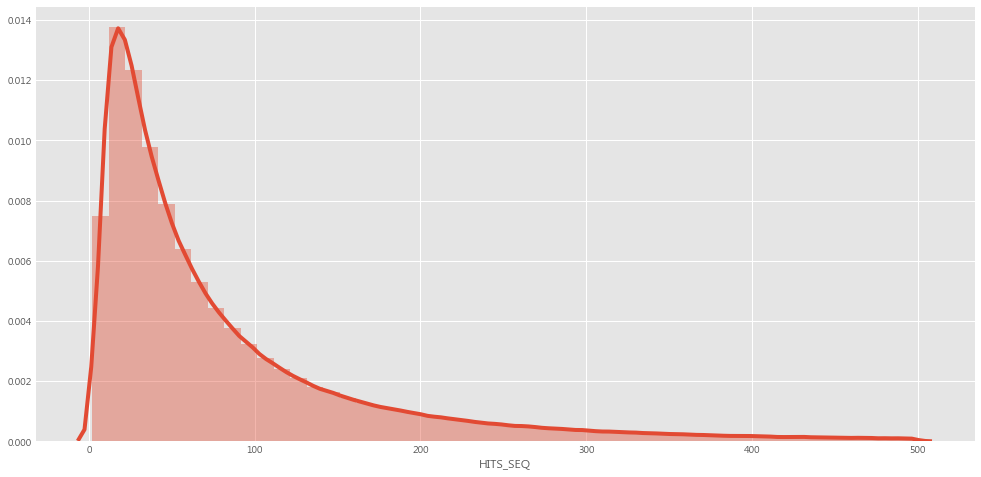

In [15]:
# HITS_SEQ의 분포
figure = plt.figure(fig.size=(15,8))
sns.distplot(Product['HITS_SEQ'])

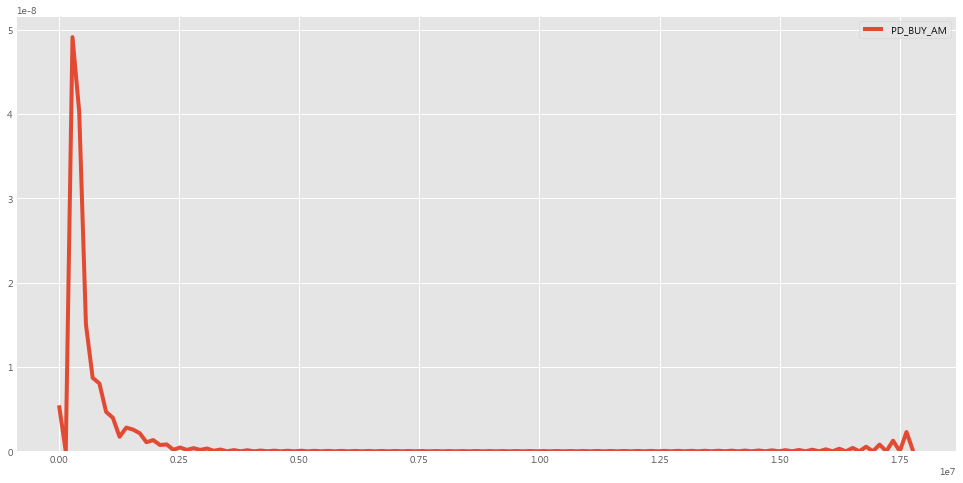

In [16]:
# PD_BUY_AM 의 분포
figure = plt.figure(figsize=(15,8))
sns.kdeplot(Product['PD_BUY_AM'])

In [17]:
# 가장비싼 물건
Product[Product['PD_BUY_AM']==17779000]

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT
3424550,929827,609951,57,51344,1개,프레드릭콘스탄트시계,17779000,1


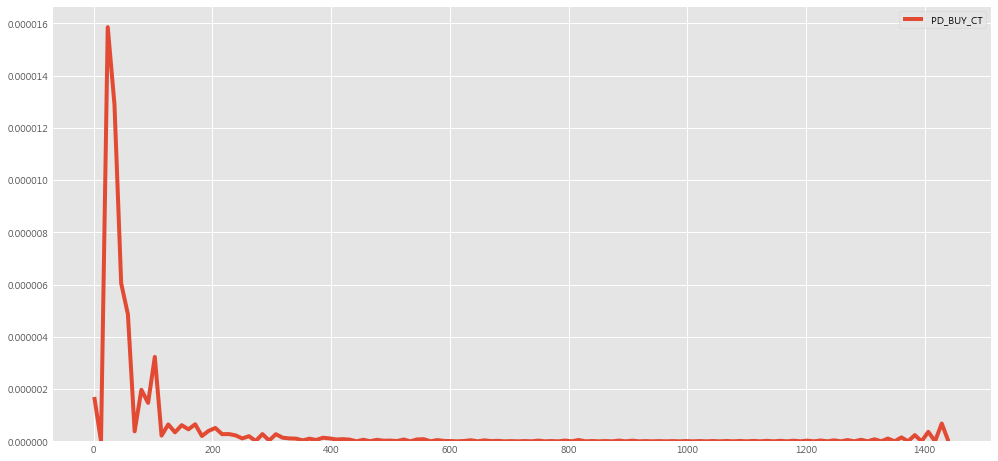

In [18]:
# PD_BUY_CT의 분포
figure = plt.figure(figsize=(15,8))
sns.kdeplot(Product['PD_BUY_CT'])

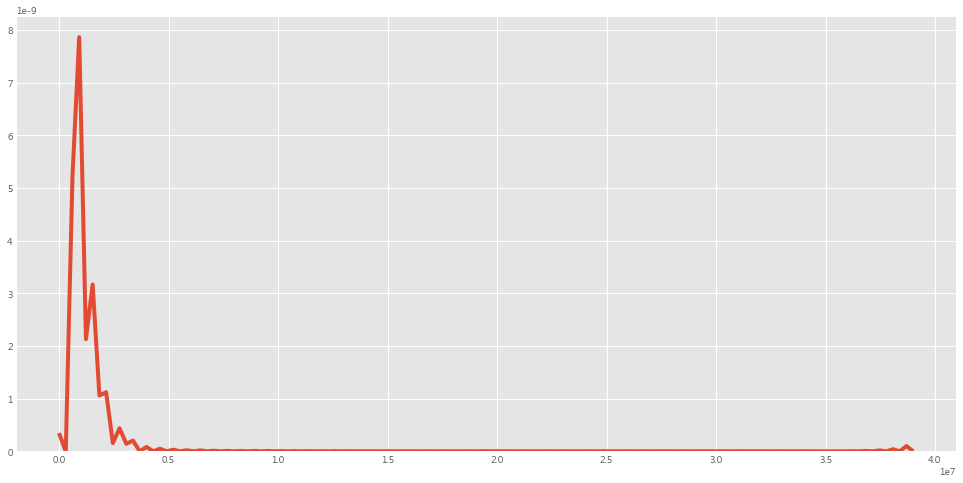

In [19]:
# 구매금액(건수*가격)의 분포
figure = plt.figure(figsize=(15,8))
sns.kdeplot(Product['PD_BUY_AM']*Product['PD_BUY_CT'])

In [20]:
BUY_CT = Product[["CLNT_ID","SESS_ID","PD_BUY_CT"]].groupby(['CLNT_ID',"SESS_ID"]).sum().reset_index()
BUY_CT['PD_BUY_CT'].describe()

count    2.708872e+06
mean     2.182634e+00
std      6.407434e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.420000e+03
Name: PD_BUY_CT, dtype: float64

In [21]:
# 구매건수의 최대값은 2420건 , 평균 구매 건수 : 2.182634건, 최소 구매건수 1건

In [22]:
BUY_price = Product[["CLNT_ID","SESS_ID","PD_BUY_AM","PD_BUY_CT"]].groupby(['CLNT_ID',"SESS_ID"]).sum().reset_index()
BUY_price['PD_BUY_price'] = BUY_price['PD_BUY_AM'] * BUY_price['PD_BUY_CT']
BUY_price['PD_BUY_price'].describe()

count    2.708872e+06
mean     2.782940e+05
std      3.719853e+06
min      1.000000e+01
25%      3.250000e+04
50%      7.500000e+04
75%      1.960000e+05
max      1.542517e+09
Name: PD_BUY_price, dtype: float64

In [23]:
# 총구매금액의 최대값 : 1542517000, 평균 총구매금액 : 75000, 총구매금액의 최소값 : 10

In [24]:
BUY_price['PD_BUY_AM'].min()

10

In [25]:
BUY_price['PD_BUY_CT'].min()

1

In [26]:
# 상품가격이 100원 이하
Product[Product['PD_BUY_AM']<=100]

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT
263,2543200,10683905,5,402140,상품명:랑방 모던 프린세스 EDP 60ml,랑방,40,115
264,1716857,10563451,22,504573,(not set),코렐,72,24
265,8752,6876615,19,207981,색상:(여)스킨 / 1개,올삭스,100,1
266,49656,2870637,16,71309,default:default,더리얼,100,5
267,59693,5939404,14,208785,색상:(남)그레이 / 1개,올삭스,100,1
268,64014,6132602,90,207981,색상:(여)스킨 / 1개,올삭스,100,1
269,64151,920193,181,783107,5개,루치펠로,100,5
270,114575,2825393,76,71306,default:default / 5개,더리얼,100,5
271,138969,6879951,28,207981,색상:(여)스킨 / 1개,올삭스,100,1
272,171668,3652310,169,207981,색상:(여)스킨 / 1개,올삭스,100,1


In [27]:
# 상품구매건수가 100개이상
Product[Product['PD_BUY_CT']>=100]

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT
263,2543200,10683905,5,402140,상품명:랑방 모던 프린세스 EDP 60ml,랑방,40,115
285,535655,6230499,44,643396,원단선택:98번/손잡이선택:구측/설치공간:천정목재,리드센스,100,342
290,748467,4495172,50,552474,제품선택:피치_우 / 391개,24,100,391
336,3110203,6258680,31,643396,원단선택:83번/손잡이선택:구측/설치공간:천정시멘트,리드센스,100,242
362,4789614,6238505,87,643396,원단선택:91번/손잡이선택:구측/설치공간:천정목재,리드센스,100,547
379,5432798,4778329,43,644852,색상선택:14번/손잡이선택:우측/설치공간선택:천정시멘트,리드센스,100,336
396,6187459,9488058,57,736543,색상:화이트 / 손잡이방향:오른쪽 / 417개,창데코,120,417
398,5524864,8660052,80,836493,색상:그레이. / 손잡이방향:우. / 필수:Q&A사이즈 / 242개,바자르,150,242
399,2149566,10562469,52,736541,색상:브라운/손잡이방향:오른쪽,창데코,160,118
405,1275411,6590321,97,828515,손잡이방향:좌측 / 172개,코지샵,180,172


- PD_BUY_AM이 100 이하인 값들 존재, 이 외에도 더 많을 것으로 추정
- PD_BUY_CT가 건수가 100개 이상인 값들 존재 
- 이런값들은 아마 이벤트성 제품들일 것으로 보임
- 이벤트성 제품들의 처리를 어떻게 해야할까?
- 이벤트성 제품들이 나온 날짜를 확인? / 이벤트성 제품들은 패턴파악이 어려우므로 제거?

In [28]:
brand = pd.DataFrame(Product['PD_BRA_NM'].value_counts())

In [29]:
brand[brand['PD_BRA_NM']<=1]

,PD_BRA_NM
바릴라,1
캐시미어하우스,1
헬베스코,1
씨엠에프알,1
미니앤모어,1
지펠,1
캔디랩,1
막스마라선글라스,1
에이치로즈,1
브리티쉬나이츠,1


- 총 판매 브랜드 중 count가 1인값들이 존재

## 1.2 Session

In [30]:
Session.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712907 entries, 0 to 2712906
Data columns (total 9 columns):
CLNT_ID            int64
SESS_ID            int64
SESS_SEQ           int64
SESS_DT            int64
TOT_PAG_VIEW_CT    float64
TOT_SESS_HR_V      object
DVC_CTG_NM         object
ZON_NM             object
CITY_NM            object
dtypes: float64(1), int64(4), object(4)
memory usage: 186.3+ MB


In [31]:
Session.head()

,CLNT_ID,SESS_ID,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,ZON_NM,CITY_NM
0,5873599,8641867,9,20180509,82.0,"1,890",mobile,Daejeon,Daejeon
1,5873599,6616320,21,20180611,105.0,"1,604",mobile,Busan,Busan
2,5873599,5886172,40,20180624,41.0,632,mobile,Daejeon,Daejeon
3,5873884,1050889,15,20180913,160.0,"1,035",mobile,Gyeonggi-do,Anyang
4,5874461,10298270,5,20180412,13.0,298,mobile,Seoul,Seoul


In [9]:
# int형인 SESS_DT를 datetime형태로 형변환
Session['SESS_DT'] = pd.to_datetime(Session['SESS_DT'],format="%Y%m%d")

# year는 2018로 동일하므로 월 / 일 / 요일 변수를 새롭게 만듬
# SESS_DT는 병합에 사용될 수 있는 변수이므로 일단 제거 X
Session['SESS_MONTH'] = Session['SESS_DT'].dt.month
Session['SESS_DAY'] = Session['SESS_DT'].dt.day
Session['SESS_WEEK'] = Session['SESS_DT'].dt.weekday

In [10]:
# Session['TOT_SESS_HR_V']의 결측치 15000여개의 결측치 삭제
Session = Session[Session['TOT_SESS_HR_V'].notnull()]

# Session TOT_SESS_HR_V 의 형변환 (object -> int64)
Session['TOT_SESS_HR_V'] = Session['TOT_SESS_HR_V'].astype(str)
Session['TOT_SESS_HR_V'] = Session['TOT_SESS_HR_V'].str.replace(',','')
Session['TOT_SESS_HR_V'] = Session['TOT_SESS_HR_V'].astype(int)

- TOT_PAG_VIEW_CT 의 결측치 처리

In [11]:
# 예측변수에 사용하기위해 숫자로 매핑시킴
Session['DVC_CTG_NM'] = Session['DVC_CTG_NM'].map({'mobile':1,"desktop":2,'tablet':3})

In [12]:
# 총 9개의 결측치 존재 9개의 결측치는 삭제보다는 다른변수들을 이용하여 선형회귀예측값을 사용하는게 용이해 보임
from sklearn.linear_model import LinearRegression
Session_1 = Session[['SESS_SEQ','TOT_PAG_VIEW_CT','TOT_SESS_HR_V','DVC_CTG_NM']]

linreg = LinearRegression()

x_train = Session_1[Session_1['TOT_PAG_VIEW_CT'].notnull()].drop(columns='TOT_PAG_VIEW_CT')
y_train = Session_1[Session_1['TOT_PAG_VIEW_CT'].notnull()]['TOT_PAG_VIEW_CT']
x_test = Session_1[Session_1['TOT_PAG_VIEW_CT'].isnull()].drop(columns='TOT_PAG_VIEW_CT')
y_test = Session_1[Session_1['TOT_PAG_VIEW_CT'].isnull()]['TOT_PAG_VIEW_CT']

linreg.fit(x_train, y_train)

predicted = linreg.predict(x_test)

Session.TOT_PAG_VIEW_CT[Session.TOT_PAG_VIEW_CT.isnull()] = predicted

In [13]:
# 얘만 float형이면 헷갈리니까 그냥 int형으로 변환
Session['TOT_PAG_VIEW_CT'] = Session['TOT_PAG_VIEW_CT'].astype(int)

In [37]:
Session.isnull().sum()

CLNT_ID            0
SESS_ID            0
SESS_SEQ           0
SESS_DT            0
TOT_PAG_VIEW_CT    0
TOT_SESS_HR_V      0
DVC_CTG_NM         0
ZON_NM             0
CITY_NM            0
SESS_MONTH         0
SESS_DAY           0
SESS_WEEK          0
dtype: int64

In [38]:
# 예측변수에 사용하기위해 숫자로 매핑시킨걸 다시 문자로 매핑
# 다시 예측변수로 사용시 재매핑
Session['DVC_CTG_NM'] = Session['DVC_CTG_NM'].map({1:'mobile',2:"desktop",3:'tablet'})

In [39]:
Session.head()

,CLNT_ID,SESS_ID,SESS_SEQ,SESS_DT,TOT_PAG_VIEW_CT,TOT_SESS_HR_V,DVC_CTG_NM,ZON_NM,CITY_NM,SESS_MONTH,SESS_DAY,SESS_WEEK
0,5873599,8641867,9,2018-05-09,82,1890,mobile,Daejeon,Daejeon,5,9,2
1,5873599,6616320,21,2018-06-11,105,1604,mobile,Busan,Busan,6,11,0
2,5873599,5886172,40,2018-06-24,41,632,mobile,Daejeon,Daejeon,6,24,6
3,5873884,1050889,15,2018-09-13,160,1035,mobile,Gyeonggi-do,Anyang,9,13,3
4,5874461,10298270,5,2018-04-12,13,298,mobile,Seoul,Seoul,4,12,3


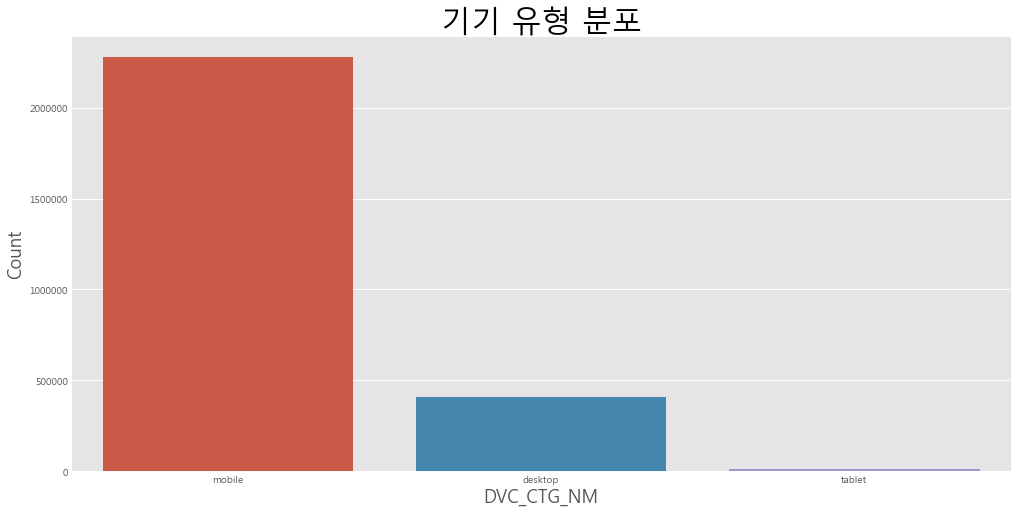

In [40]:
plt.figure(figsize=(15,8))
sns.countplot(Session['DVC_CTG_NM'])
plt.title("기기 유형 분포", fontsize=30)
plt.xlabel('DVC_CTG_NM', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.show()

In [ ]:
# 대부분이 모바일로 접속
# 태블릿접속은 거의 드물다

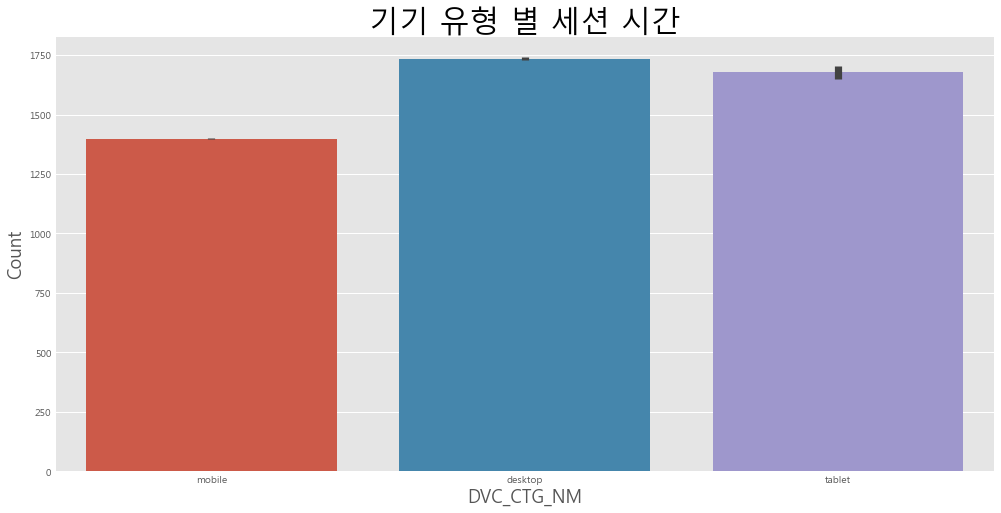

In [41]:
figure = plt.figure(figsize=(15,8))
sns.barplot(data = Session , x= 'DVC_CTG_NM',y='TOT_SESS_HR_V')
plt.title("기기 유형 별 세션 시간", fontsize=30)
plt.xlabel('DVC_CTG_NM', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.show()

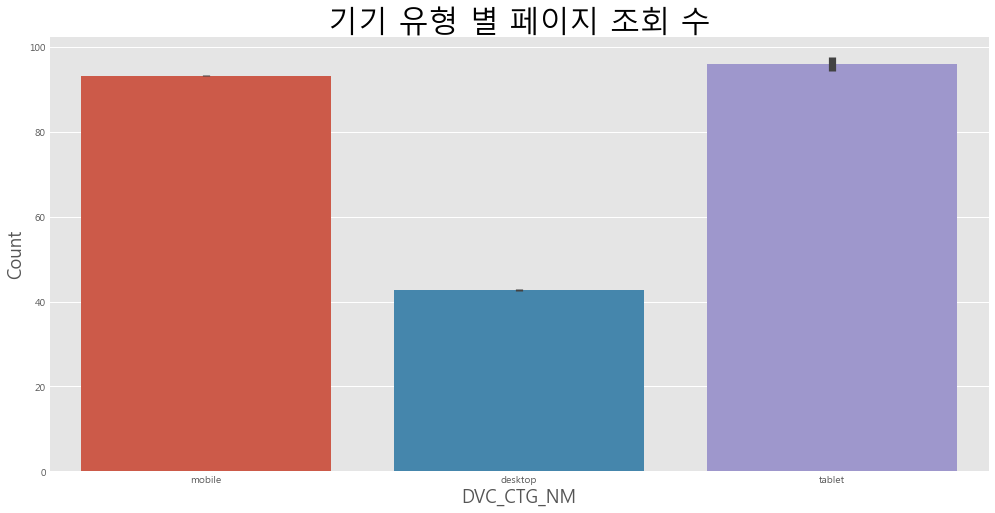

In [42]:
figure = plt.figure(figsize=(15,8))
sns.barplot(data = Session , x= 'DVC_CTG_NM',y='TOT_PAG_VIEW_CT')
plt.title("기기 유형 별 페이지 조회 수", fontsize=30)
plt.xlabel('DVC_CTG_NM', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.show()

In [ ]:
# 모바일로 접속하는 경우가 월등히 많아 비교하기 어렵지만
# 그래도 알수있는 것은 Desktop으로 접속할경우 세션시간이 길고
# 모바일로 접속하면 페이지뷰가 많아짐
# 태블릿은 비교불가해보임(너무적음)

In [45]:
data = Session.groupby('DVC_CTG_NM')['TOT_SESS_HR_V'].mean()
data

DVC_CTG_NM
desktop    1735.619719
mobile     1399.340542
tablet     1676.929155
Name: TOT_SESS_HR_V, dtype: float64

Seoul                1013369
Gyeonggi-do           467586
Busan                 294509
Gyeongsangnam-do      128177
Daegu                 116189
Incheon               100249
Gyeongsangbuk-do       90806
Jeollabuk-do           78160
Chungcheongnam-do      77714
Gwangju                70532
Daejeon                60197
Jeollanam-do           49078
Ulsan                  46393
Chungcheongbuk-do      44242
Gangwon-do             42494
Jeju-do                19010
Name: ZON_NM, dtype: int64


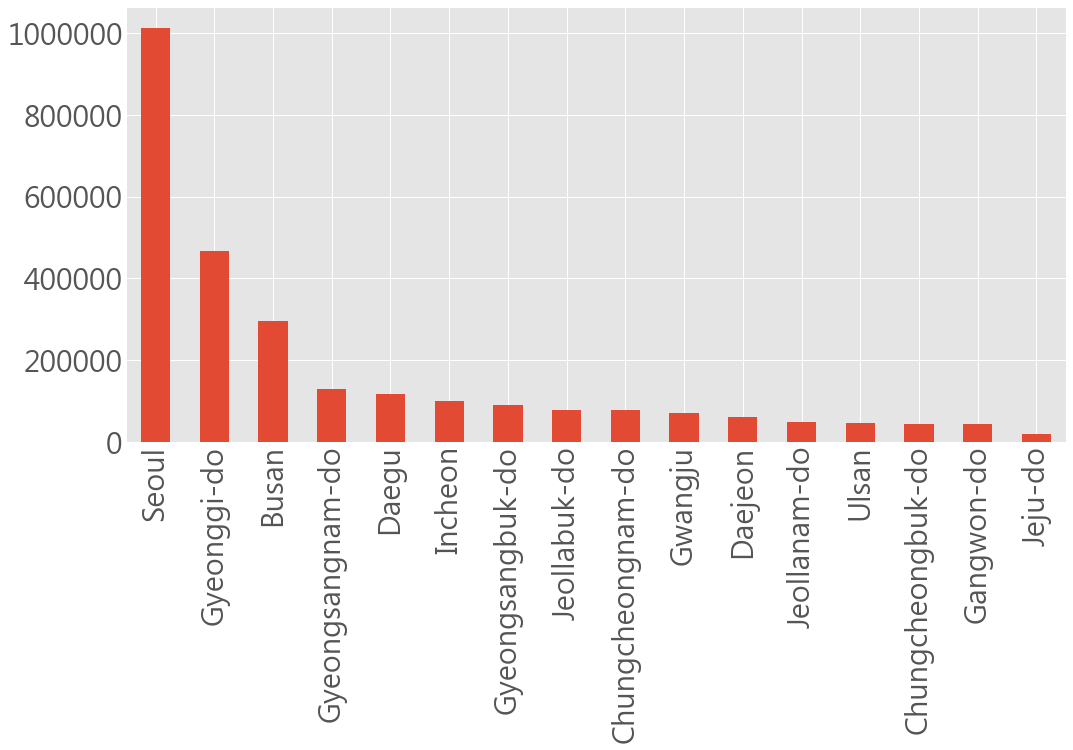

In [51]:
# 지역별 구매 count
fig = plt.figure(figsize=(15,8))
print(Session['ZON_NM'].value_counts())
Session['ZON_NM'].value_counts().plot(kind='bar',fontsize=30)

In [52]:
data = Session['CITY_NM'].value_counts().nlargest(10)
data

Seoul        1013368
Busan         294509
Daegu         116189
Incheon       100248
Gwangju        70532
Daejeon        60197
Gimhae-si      48925
Goyang-si      47424
Suwon-si       46899
Ulsan          46393
Name: CITY_NM, dtype: int64

Seoul        1013368
Busan         294509
Daegu         116189
Incheon       100248
Gwangju        70532
Daejeon        60197
Gimhae-si      48925
Goyang-si      47424
Suwon-si       46899
Ulsan          46393
Name: CITY_NM, dtype: int64


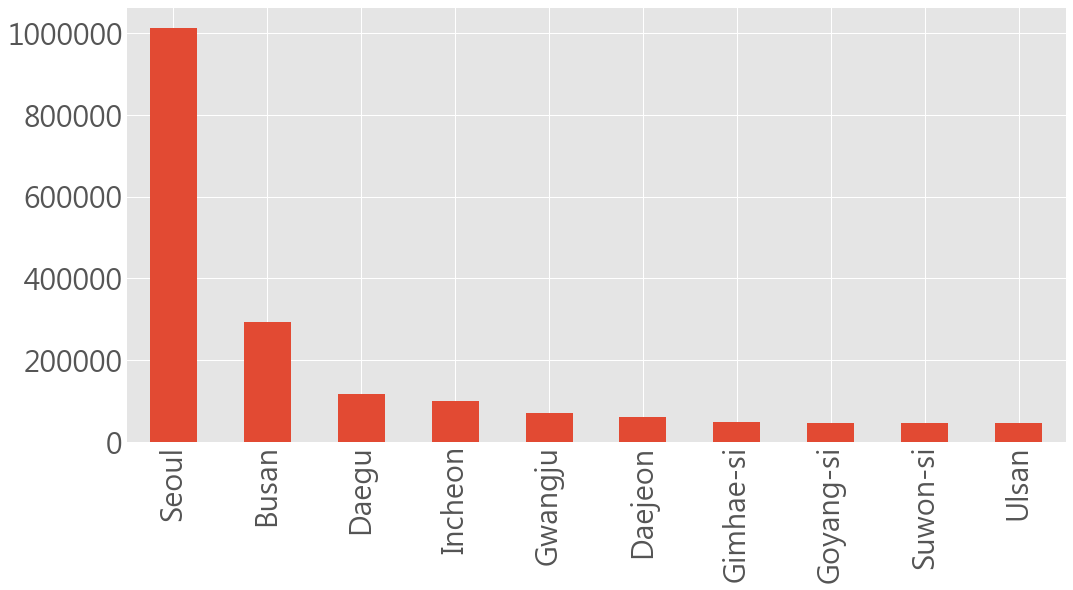

In [53]:
# 도시별 구매 count
fig = plt.figure(figsize=(15,8))
data = Session['CITY_NM'].value_counts().nlargest(10)
print(data)
data.plot(kind='bar',fontsize=30)

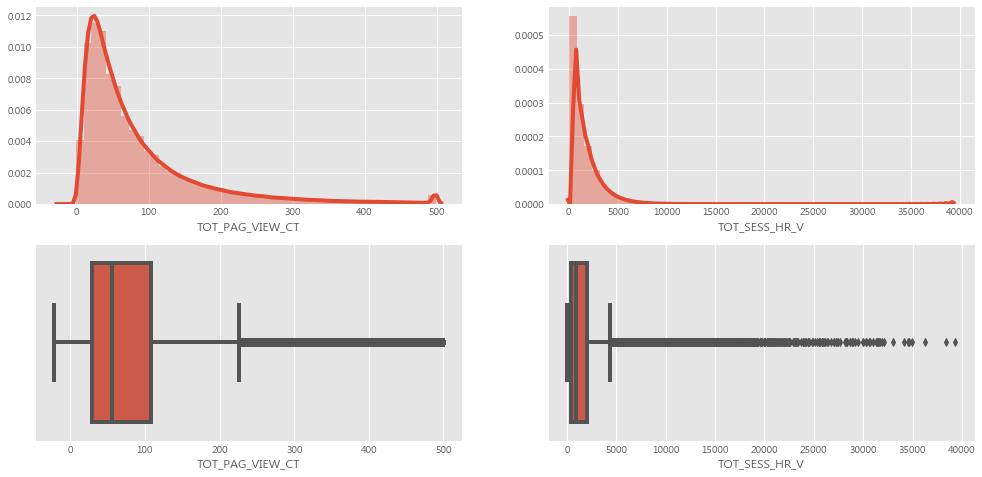

In [80]:
fig,ax = plt.subplots(2,2,figsize=(15,8))
sns.distplot(Session['TOT_PAG_VIEW_CT'],ax=ax[0][0])
sns.distplot(Session['TOT_SESS_HR_V'],ax=ax[0][1])
sns.boxplot(Session['TOT_PAG_VIEW_CT'],ax=ax[1][0])
sns.boxplot(Session['TOT_SESS_HR_V'],ax=ax[1][1])
plt.show()

## 1.3 Master

- 대분류 : 37개 / 중분류 : 128개 / 소분류 : 898 개

In [54]:
Master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847652 entries, 0 to 847651
Data columns (total 5 columns):
PD_C        847652 non-null int64
PD_NM       847652 non-null object
CLAC1_NM    847652 non-null object
CLAC2_NM    847652 non-null object
CLAC3_NM    847652 non-null object
dtypes: int64(1), object(4)
memory usage: 32.3+ MB


In [55]:
Master.head()

,PD_C,PD_NM,CLAC1_NM,CLAC2_NM,CLAC3_NM
0,64382,언더아머 남성 UA HG 아머 모크 LS 1289559-001 - 블랙 / MD[95],스포츠패션,남성일반스포츠의류,남성스포츠티셔츠
1,62282,여자 플라워덧신 2족선물세트 17403-2set,속옷/양말/홈웨어,여성양말류,여성일반양말
2,61729,88A2933253배트맨스웨트티 - 블랙 / 130,유아동의류,유아의류상의,영유아티셔츠/탑
3,61537,"닥터마틴 아드리안 블랙, 체리레드 - 02_체리레드 / 250mm(6)",패션잡화,남성화,남성부츠
4,58820,여성 그레이 스트라이프 퍼프 소매 블라우스 (128865YQ33) - 회색(앤틱실버...,남성의류,남성의류상의,남성남방셔츠


In [56]:
Master[['CLAC1_NM','CLAC2_NM','CLAC3_NM']].describe()

,CLAC1_NM,CLAC2_NM,CLAC3_NM
count,847652,847652,847652
unique,37,128,898
top,여성의류,여성의류상의,남성티셔츠
freq,181107,82731,41650


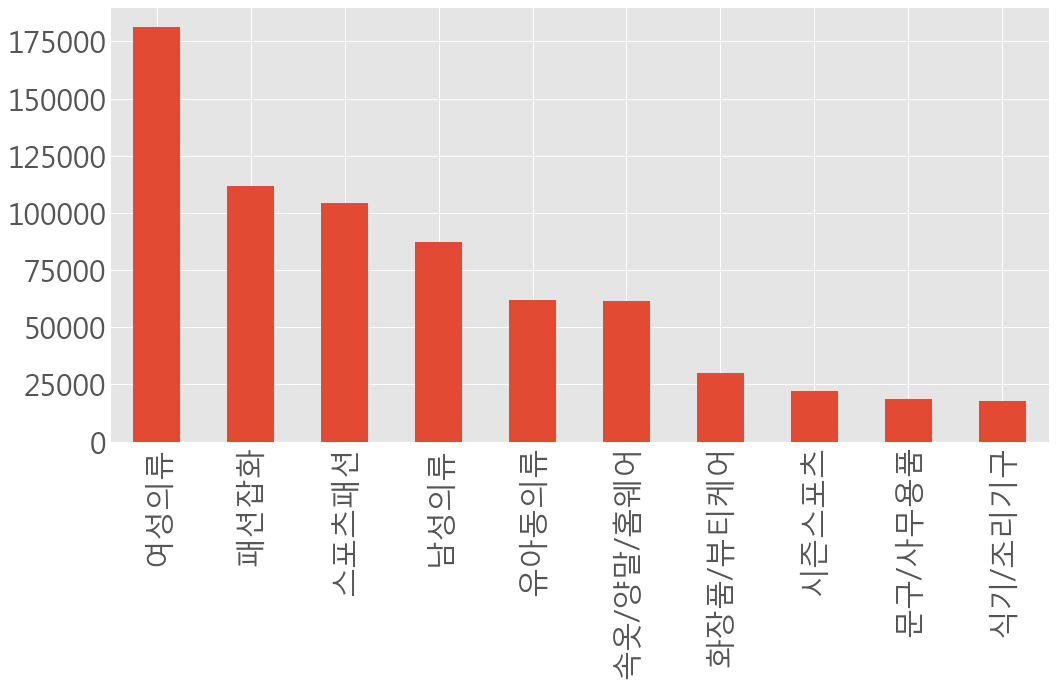

In [57]:
fig = plt.figure(figsize=(15,8))
data = Master['CLAC1_NM'].value_counts().nlargest(10)
data.plot(kind='bar',fontsize=30)

In [58]:
# 대분류 top 10
# 여성의류 - 패션잡화 - 스포츠패션 - 남성의류 - 유아동의류 - ....
# 여성의류가 압도적으로 높음

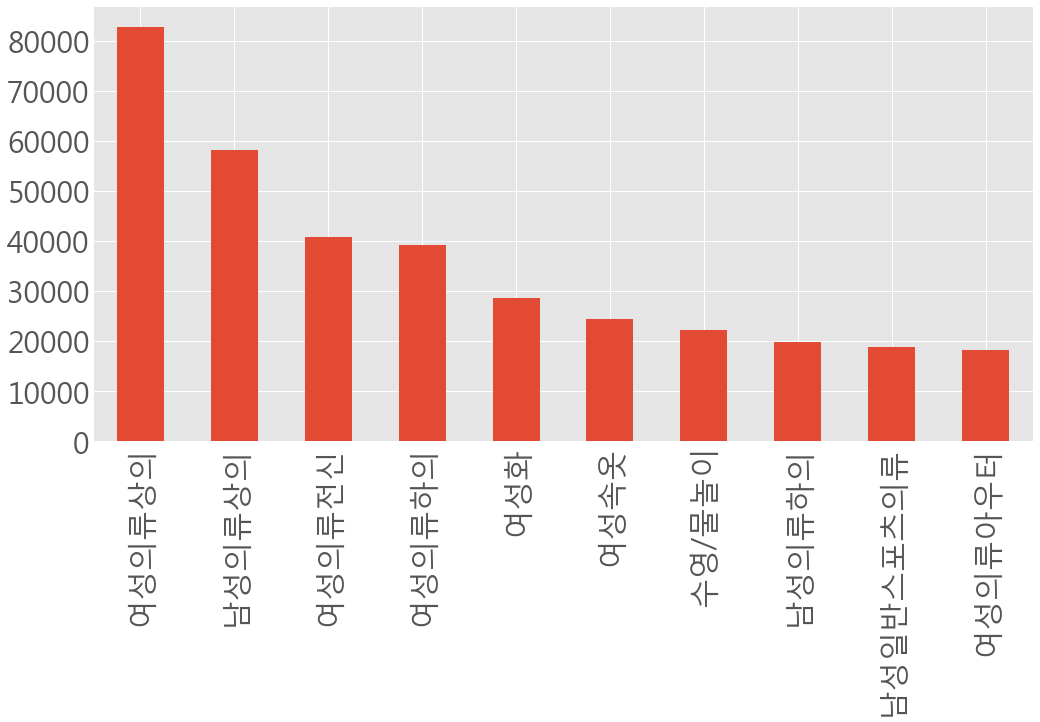

In [59]:
fig = plt.figure(figsize=(15,8))
data = Master['CLAC2_NM'].value_counts().nlargest(10)
data.plot(kind='bar',fontsize=30)

In [60]:
# 중분류 top 10
# 여성의류상의 - 남성의류상의 - 여성의류전신 - 여성의류하의 - 여성화

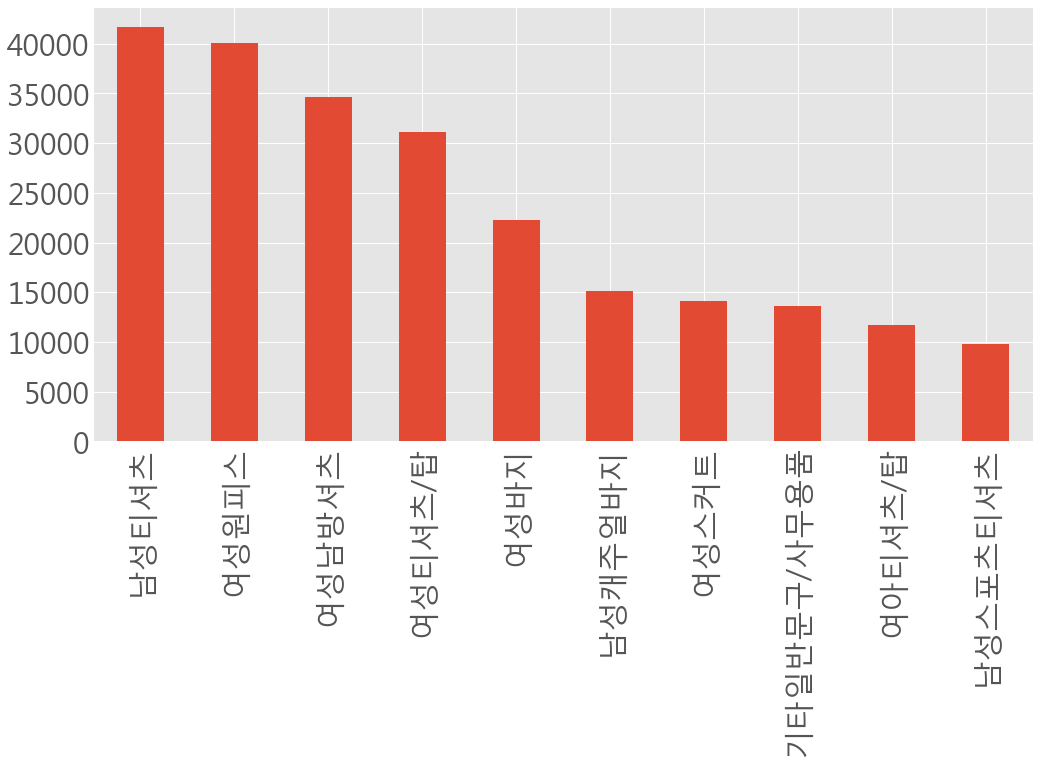

In [61]:
fig = plt.figure(figsize=(15,8))
data = Master['CLAC3_NM'].value_counts().nlargest(10)
data.plot(kind='bar',fontsize=30)

In [62]:
# 소분류 top 10 
# 남성티셔츠 - 여성원피스 - 여성남방셔츠 - 여성티셔츠/탑 - 여성바지

## 1.4 Custom

In [63]:
Custom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671679 entries, 0 to 671678
Data columns (total 3 columns):
CLNT_ID        671679 non-null int64
CLNT_GENDER    671679 non-null object
CLNT_AGE       671679 non-null int64
dtypes: int64(2), object(1)
memory usage: 15.4+ MB


In [64]:
Custom.head()

,CLNT_ID,CLNT_GENDER,CLNT_AGE
0,4830726,F,30
1,4830874,F,40
2,4830975,F,30
3,4831275,F,30
4,4825325,F,30


In [65]:
Custom.nunique()

CLNT_ID        671679
CLNT_GENDER         2
CLNT_AGE            8
dtype: int64

F    570616
M    101063
Name: CLNT_GENDER, dtype: int64


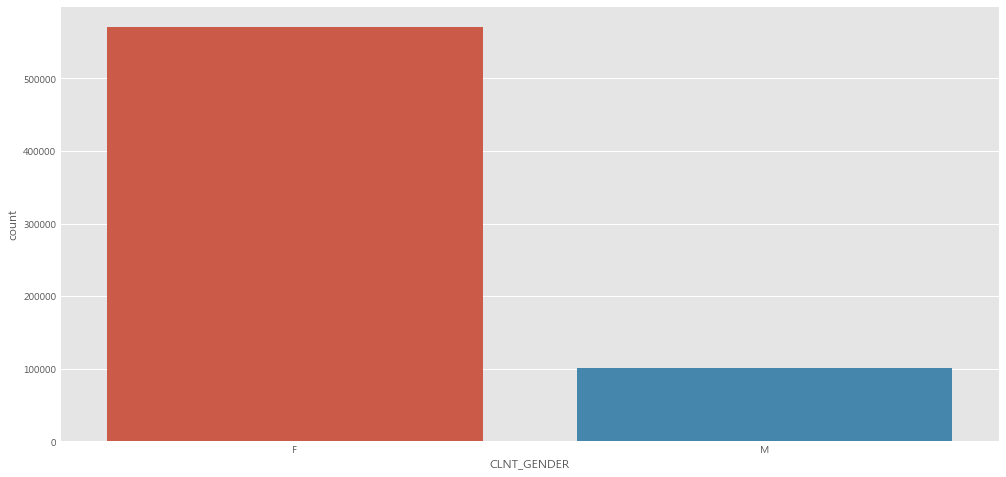

In [66]:
fig = plt.figure(figsize=(15,8))
print(Custom['CLNT_GENDER'].value_counts())
sns.countplot(Custom['CLNT_GENDER'])

In [67]:
# 여성회원수가 남성회원수보다 약 5.7배 많음

30    313600
40    216217
20     95297
50     36624
60      5256
10      3807
70       846
80        32
Name: CLNT_AGE, dtype: int64


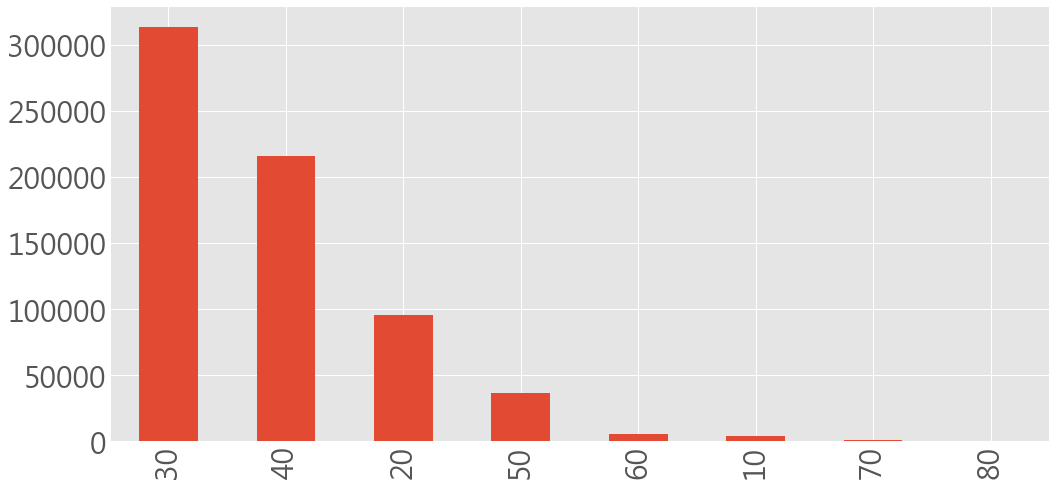

In [68]:
fig = plt.figure(figsize=(15,8))
data = Custom['CLNT_AGE'].value_counts()
print(data)
data.plot(kind='bar',fontsize=30)

In [69]:
# 30 - 40 - 20 - 50 대 ....

## 1.5 Search1

In [70]:
Search1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2884943 entries, 0 to 2884942
Data columns (total 4 columns):
CLNT_ID       int64
SESS_ID       int64
KWD_NM        object
SEARCH_CNT    int64
dtypes: int64(3), object(1)
memory usage: 88.0+ MB


In [71]:
Search1.head()

,CLNT_ID,SESS_ID,KWD_NM,SEARCH_CNT
0,5607714,7112876,빌리프 아이크림,6
1,5607714,4090791,프리메라 마스크팩,3
2,5607714,4090791,여성청결제,1
3,5612428,1876482,명품가방,1
4,5612428,658123,콩순이 아이스크림,1


In [14]:
# 검색어에 특수문자 존재 할 수 있으므로 특수문자 모두 제거
Search1['KWD_NM'] = Search1['KWD_NM'].apply(cleanText)

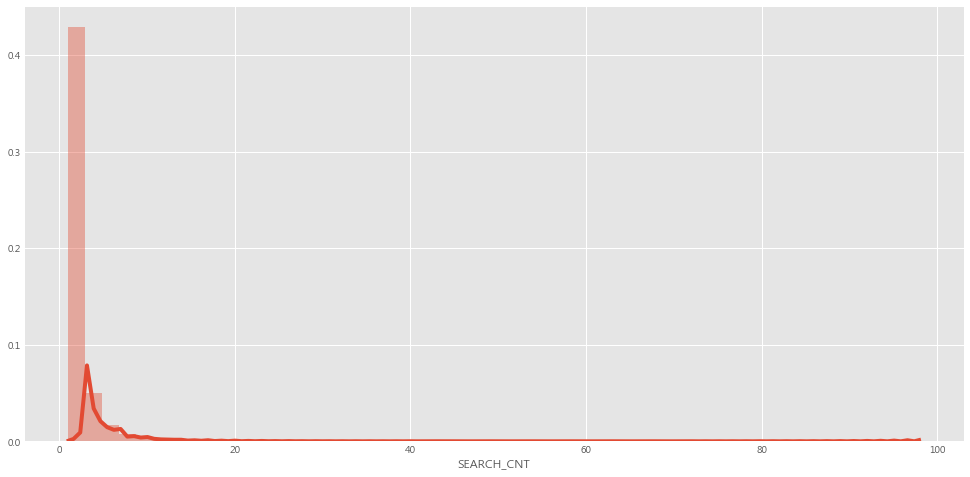

In [73]:
fig = plt.figure(figsize=(15,8))
sns.distplot(Search1["SEARCH_CNT"])

In [74]:
# 가장 많이 검색된 횟수는 한 세션에서 98번까지 이루어짐
# 대부분의 값들은 10회미만으로 검색됨

## 1.6 Search2

In [75]:
Search2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8051172 entries, 0 to 8051171
Data columns (total 3 columns):
SESS_DT       int64
KWD_NM        object
SEARCH_CNT    object
dtypes: int64(1), object(2)
memory usage: 184.3+ MB


In [76]:
Search2.head()

,SESS_DT,KWD_NM,SEARCH_CNT
0,20180407,닥스원피스,8
1,20180407,닥터지 브라이트닝,1
2,20180407,달팡 인트랄,2
3,20180407,대상트,1
4,20180407,더블유닷,6


In [15]:
# 검색어에 특수문자 존재 할 수 있으므로 특수문자 모두 제거
Search2['KWD_NM'] = Search2['KWD_NM'].apply(cleanText)

# 2. 데이터 병합
- Product + Session + Master + Custom - > df1
- Product + + Master + Search1 -> df2

In [16]:
df_2_PM = pd.merge(Product,Master,on=['PD_C'],how='left')

In [17]:
df_2 = pd.merge(df_2_PM,Search1,on=['CLNT_ID','SESS_ID'],how = 'left')
df_2.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,PD_NM,CLAC1_NM,CLAC2_NM,CLAC3_NM,KWD_NM,SEARCH_CNT
0,4139680,7605037,12,642112,색상워터멜론,바비브라운,39000,1,크러쉬드 립칼라 - 플럼,화장품/뷰티케어,메이크업,블러셔/쉐이딩/하이라이터,NaN,NaN
1,4140076,10189797,13,570603,색상BLK0_BLK0BLACK 사이즈120 2개,데상트,39000,2,[데상트] 스포츠베이직 빅로고 티셔츠 - DMGR_DMELANGE / 115,스포츠패션,남성일반스포츠의류,남성스포츠티셔츠,NaN,NaN
2,4142395,6158159,85,179538,not set,아베다,39000,1,[단독][6월] 라이트 엘리먼츠 헤어 에센스 세트,퍼스널케어,헤어케어,헤어케어선물세트,입생로랑,3.0
3,4142395,6158159,85,179538,not set,아베다,39000,1,[단독][6월] 라이트 엘리먼츠 헤어 에센스 세트,퍼스널케어,헤어케어,헤어케어선물세트,이솝,3.0
4,4142395,6158159,85,179538,not set,아베다,39000,1,[단독][6월] 라이트 엘리먼츠 헤어 에센스 세트,퍼스널케어,헤어케어,헤어케어선물세트,아베다 스무드,1.0


In [137]:
df_2.shape

(9019420, 14)

In [ ]:
# 검색어없이 구매된 데이터가 있음 
# 클릭만 해서 구매했거나 혹은 오류값이거나
# 특수문자 제거 과정에서 검색어가 공백이 된것들이 존재
# 원래 특수문자 밖에 없었으므로 제거해도 무방

In [18]:
# 공백, nan값 제거
df_2 = df_2[df_2['KWD_NM']!='']
df_2 = df_2[df_2['KWD_NM'].notnull()]
df_2.shape

(6438230, 14)

In [142]:
df_2.isnull().sum()

CLNT_ID       0
SESS_ID       0
HITS_SEQ      0
PD_C          0
PD_ADD_NM     0
PD_BRA_NM     0
PD_BUY_AM     0
PD_BUY_CT     0
PD_NM         0
CLAC1_NM      0
CLAC2_NM      0
CLAC3_NM      0
KWD_NM        0
SEARCH_CNT    0
dtype: int64

In [19]:
# 문장의 유사도 분석
# (KWD_NM과 PD_BRA_NM의 공통 단어) / (KWD_NM의 단어)
# 단어를 2음절씩 나눈이유 : 2음절씩 나누면 문장의 단어를 최대한 세분화해서볼수있음
# 1개는 단어의 의미를 잃기 때문에 안됨

## n_gram
def ngram(s,num):
    res = []
    slen = len(s)#-num+1
    for i in range(slen):
        ss = s[i:i+num]
        res.append(ss)
    return res

def diff_ngram(sa,sb,num):
    a = ngram(sa,num)
    b = ngram(sb,num)
    r = []
    cnt = 0
    for i in a:
        for j in b:
            if i==j:
                cnt +=1
                r.append(i)
    return cnt / len(b), r
# 겹치는 단어가 어떤건지 필요하면 r 도 함께 return

In [20]:
def search_index(df,a):
    r = []
    for i in range(len(df)):
        rr = diff_ngram(df[a].iloc[i],df["KWD_NM"].iloc[i],2)
        r.append(rr)
    return r

In [141]:
# 예시
print(ngram(df_2['KWD_NM'].iloc[16],2))
print(ngram(df_2['PD_BRA_NM'].iloc[16],2))
print(df_2['PD_BRA_NM'].iloc[16],df_2['KWD_NM'].iloc[16])
r2= diff_ngram(df_2['PD_BRA_NM'].iloc[16],df_2['KWD_NM'].iloc[16],2)
print(r2)

['나이', '이키', '키 ', ' 나', '나시', '시']
['나이', '이키', '키의', '의류', '류']
나이키의류 나이키 나시
0.3333333333333333


In [125]:
df_2.shape

(6438289, 10)

In [126]:
df_2.head()

,CLNT_ID,SESS_ID,HITS_SEQ,PD_C,PD_ADD_NM,PD_BRA_NM,PD_BUY_AM,PD_BUY_CT,KWD_NM,SEARCH_CNT
2,4142395,6158159,85,179538,(not set),아베다,39000,1,입생로랑,3.0
3,4142395,6158159,85,179538,(not set),아베다,39000,1,이솝,3.0
4,4142395,6158159,85,179538,(not set),아베다,39000,1,아베다 스무드,1.0
5,4142395,6158159,85,179538,(not set),아베다,39000,1,아베다,23.0
7,4144917,6406509,78,190306,5개,데코르테,39000,5,코스메 데코르테,8.0


In [21]:
r = []
for i in range(len(df_2)):
    rr = diff_ngram(df_2['PD_BRA_NM'].iloc[i],df_2['KWD_NM'].iloc[i],2)
    r.append(rr)

In [22]:
df_2['brand_search'] = r

In [23]:
a = search_index(df_2,'PD_ADD_NM')

In [24]:
a

[(0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.1111111111111111, ['6 ']),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []),
 (0.0, []